# Data & Lib

In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge,Lasso
from skforecast.model_selection import backtesting_forecaster, grid_search_forecaster
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

/Users/navidmohamadi/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/navidmohamadi/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


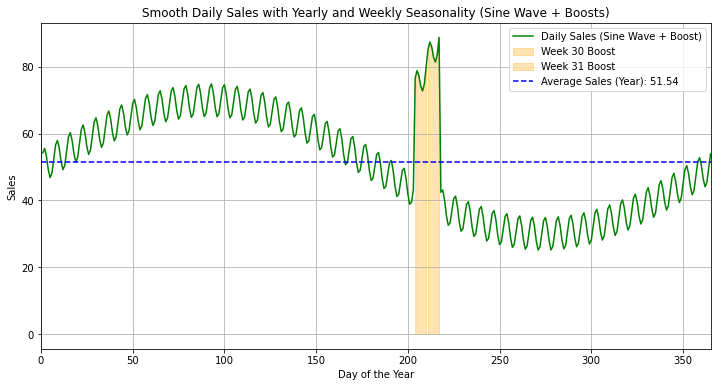

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Number of days in a year
num_days = 365

# Generate day numbers
day_numbers = np.arange(1, num_days + 1)

# Create a smooth sine wave with annual seasonality (1 cycle per year)
annual_cycle = 20 * np.sin(2 * np.pi * day_numbers / 365)  # Sine wave pattern for yearly seasonality

# Add a smoother weekend effect
weekend_effect = 5 * np.sin(2 * np.pi * (day_numbers % 7) / 7)

# Generate sales data: base value + annual cycle + weekend effect
sales_data = 50 + annual_cycle + weekend_effect  # No random noise

# Calculate week number and day of the week
week_numbers = (day_numbers - 1) // 7 + 1
day_of_week = (day_numbers - 1) % 7

# Introduce boosts in sales for weeks 30 and 31
boost_weeks = (week_numbers >= 30) & (week_numbers <= 31)
boost_amount = np.linspace(30, 50, np.sum(boost_weeks))  # Smooth boost amount
sales_data[boost_weeks] += boost_amount  # Add the boost to weeks 30 and 31

# Create a DataFrame
df = pd.DataFrame({
    'Day': day_numbers,
    'Sales': sales_data,
    'Week_Number': week_numbers,
    'Day_of_the_Week': day_of_week
})

# Calculate average sales over the year
average_sales_year = df['Sales'].mean()

# Convert columns to numpy arrays
day_array = df['Day'].to_numpy()
sales_array = df['Sales'].to_numpy()

# Plot the smooth sine wave data with boosts
plt.figure(figsize=(12, 6))
plt.plot(day_array, sales_array, label='Daily Sales (Sine Wave + Boost)', color='green')

# Highlight weeks 30 and 31
for week in [30, 31]:
    plt.fill_between(df['Day'], df['Sales'], where=(df['Week_Number'] == week), color='orange', alpha=0.3, label=f'Week {week} Boost')

# Add horizontal line for average sales
plt.axhline(y=average_sales_year, color='blue', linestyle='--', label=f'Average Sales (Year): {average_sales_year:.2f}')

# Adjust plot limits and labels
plt.xlim([0, num_days])
plt.title('Smooth Daily Sales with Yearly and Weekly Seasonality (Sine Wave + Boosts)')
plt.xlabel('Day of the Year')
plt.ylabel('Sales')
plt.grid(True)
plt.legend()
plt.show()

<Figure size 864x432 with 0 Axes>

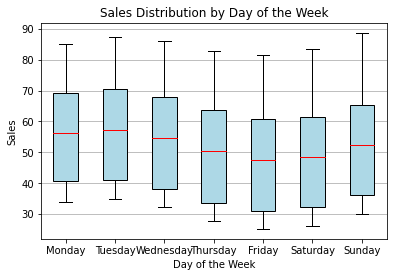

In [59]:
#Plot the box plot for sales over each day of the week
plt.figure(figsize=(12, 6))
df.boxplot(column='Sales', by='Day_of_the_Week', grid=False, patch_artist=True, 
           boxprops=dict(facecolor='lightblue', color='black'), 
           medianprops=dict(color='red'), 
           whiskerprops=dict(color='black'))

# Customize the plot
plt.title('Sales Distribution by Day of the Week')
plt.suptitle('')  # Suppress the automatic title to avoid overlap with the main title
plt.xlabel('Day of the Week')
plt.ylabel('Sales')
plt.xticks(ticks=np.arange(1, 8), labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.grid(axis='y')
plt.show()

In [60]:
df

,Day,Sales,Week_Number,Day_of_the_Week
0,1,54.253425,1,0
1,2,55.563072,1,1
2,3,53.201812,1,2
3,4,49.206630,1,3
4,5,46.844656,1,4
...,...,...,...,...
360,361,46.454533,52,3
361,362,44.092967,52,4
362,363,45.402410,52,5
363,364,49.655733,52,6


## Encoding week using sin/cos instead of one-hot encoding

matplotlib.legend WARNING No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


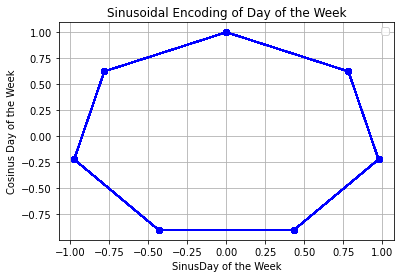

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Number of days in a week
days_of_week = np.arange(7)  # Correctly define an array from 0 to 6

# Assuming df is already defined and contains 'Day_of_the_Week' column
df['Day_of_the_Week_Sin'] = df['Day'].apply(lambda x : np.sin(2 * np.pi * x / 7))
df['Day_of_the_Week_Cos'] = df['Day'].apply(lambda x : np.cos(2 * np.pi * x / 7))
df['Day_of_the_Month_Sin'] = df['Day'].apply(lambda x : np.sin(2 * np.pi * x / 30))
df['Day_of_the_Month_Cos'] = df['Day'].apply(lambda x : np.cos(2 * np.pi * x / 30))
df['Day_of_the_Year_Sin'] = np.sin(2 * np.pi * df['Day'] / 365)
df['Day_of_the_Year_Cos'] = np.cos(2 * np.pi * df['Day'] / 365)

sin_array = df['Day_of_the_Week_Sin'].to_numpy()
cos_array = df['Day_of_the_Week_Cos'].to_numpy()


# Plot sine encoding

plt.plot(sin_array, cos_array, marker='o', color='blue', linestyle='-')

plt.xlabel('SinusDay of the Week')
plt.ylabel('Cosinus Day of the Week')
plt.title('Sinusoidal Encoding of Day of the Week')
plt.grid(True)
plt.legend()




# Forecaster

In [63]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from sklearn.model_selection import TimeSeriesSplit

# Ensure dataframe has a RangeIndex
df = df.reset_index(drop=True)



# Define start and end indices for the boost weeks
start_week_index = int(df.loc[df['Week_Number'].isin([30, 31])].index.min())
end_week_index = int(df.loc[df['Week_Number'].isin([30, 31])].index.max())
duration = 14

# Feature Engineering
temp = df[:end_week_index + 1 + duration].copy()

# Log-transform sales to stabilize variance
temp['log_sales'] = np.log(temp['Sales'])

# Adding moving average of log_sales
temp['log_sales_ma'] = np.log(temp['Sales'].shift(1).rolling(window=7, min_periods=1).mean().bfill())

# Defining exogenous variables
exog_vars = ['Day_of_the_Week_Sin', 'Day_of_the_Week_Cos', 'log_sales_ma', 
             'Day_of_the_Year_Sin', 'Day_of_the_Year_Cos',
             'Day_of_the_Month_Sin', 'Day_of_the_Month_Cos']

# Backtesting and train-test split based on duration
n_backtesting = duration * 2 + min(duration, len(temp) - end_week_index)
train_size = len(temp) - n_backtesting
train_data = temp.iloc[:train_size].copy()

# Tuning and model fitting
forecaster = ForecasterAutoreg(
    regressor=Ridge(fit_intercept=True, random_state=123),
    lags=4
)

# Lag grid and parameter grid for tuning
lags_grid = [1, 2, 4, 6, 8, 12, 30]
param_grid = {'alpha': [0.01, 0.1, 0.5, 0.8, 1, 1.5, 2, 3, 5, 10, 20, 40]}

# Perform grid search with time-series cross-validation
tscv = TimeSeriesSplit(n_splits=5)  # Cross-validation for time series
forecaster_tuned = grid_search_forecaster(
    forecaster=forecaster,
    y=train_data['log_sales'],
    param_grid=param_grid,
    lags_grid=lags_grid,
    exog=train_data[exog_vars],
    steps=1,
    allow_incomplete_fold=True,
    refit=True,
    metric='mean_absolute_percentage_error',
    initial_train_size=40,
    return_best=True,
    verbose=False
)

# Display the best parameters found
print(forecaster_tuned)

# Optional: Use XGBoost for comparison
from xgboost import XGBRegressor
forecaster_xgb = ForecasterAutoreg(
    regressor=XGBRegressor(objective='reg:squarederror', random_state=123),
    lags=4
)

param_grid_xgb = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.05, 0.1, 0.2]}
forecaster_xgb_tuned = grid_search_forecaster(
    forecaster=forecaster_xgb,
    y=train_data['log_sales'],
    param_grid=param_grid_xgb,
    lags_grid=lags_grid,
    exog=train_data[exog_vars],
    steps=1,
    allow_incomplete_fold=True,
    refit=True,
    metric='mean_absolute_percentage_error',
    initial_train_size=40,
    return_best=True,
    verbose=False
)

# Evaluate both Ridge and XGBoost models

Number of models compared: 84.


lags grid:   0%|          | 0/7 [00:00<?, ?it/s]

params grid:   0%|          | 0/12 [00:00<?, ?it/s]

/Users/navidmohamadi/opt/anaconda3/lib/python3.9/site-packages/skforecast/model_selection/model_selection.py:475: LongTrainingWarning: The forecaster will be fit 149 times. This can take substantial amounts of time. If not feasible, try with `refit = False`.
 
 You can suppress this warning using: warnings.simplefilter('ignore', category=LongTrainingWarning)
  warnings.warn(
/Users/navidmohamadi/opt/anaconda3/lib/python3.9/site-packages/skforecast/model_selection/model_selection.py:475: LongTrainingWarning: The forecaster will be fit 149 times. This can take substantial amounts of time. If not feasible, try with `refit = False`.
 
 You can suppress this warning using: warnings.simplefilter('ignore', category=LongTrainingWarning)
  warnings.warn(
/Users/navidmohamadi/opt/anaconda3/lib/python3.9/site-packages/skforecast/model_selection/model_selection.py:475: LongTrainingWarning: The forecaster will be fit 149 times. This can take substantial amounts of time. If not feasible, try with `r

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] 
  Parameters: {'alpha': 0.01}
  Backtesting metric: 0.0005604968345057404

                                                 lags  \
72  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
60            [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]   
73  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
48                           [1, 2, 3, 4, 5, 6, 7, 8]   
36                                 [1, 2, 3, 4, 5, 6]   
..                                                ...   
22                                             [1, 2]   
34                                       [1, 2, 3, 4]   
35                                       [1, 2, 3, 4]   
23                                             [1, 2]   
11                                                [1]   

                                           lags_l

lags grid:   0%|          | 0/7 [00:00<?, ?it/s]

params grid:   0%|          | 0/12 [00:00<?, ?it/s]

/Users/navidmohamadi/opt/anaconda3/lib/python3.9/site-packages/skforecast/model_selection/model_selection.py:475: LongTrainingWarning: The forecaster will be fit 149 times. This can take substantial amounts of time. If not feasible, try with `refit = False`.
 
 You can suppress this warning using: warnings.simplefilter('ignore', category=LongTrainingWarning)
  warnings.warn(
/Users/navidmohamadi/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/navidmohamadi/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/navidmohamadi/opt/anaconda3/lib/python3.9/site-packages/pandas/core

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7 8] 
  Parameters: {'learning_rate': 0.05, 'n_estimators': 200}
  Backtesting metric: 0.0024598009119745044



In [84]:
alpha = 0.01#forecaster_tuned.sort_values('mean_absolute_percentage_error').iloc[0]['alpha']
lags = 30#forecaster_tuned.sort_values('mean_absolute_percentage_error').iloc[0]['lags'][forecaster_tuned.sort_values('mean_absolute_percentage_error').iloc[0]['lags'].shape[0]-1]

'''building model'''

regressor = Ridge(fit_intercept=True,alpha=alpha,random_state=123)
forecaster = ForecasterAutoreg(
    regressor=  regressor,
    lags=lags
)

forecaster.fit(y=train_data['log_sales'],exog=train_data[exog_vars])

_,predictions_backtest = backtesting_forecaster(forecaster,
                                          y = temp['log_sales'],
                                          exog = temp[exog_vars],
                                          steps = 1,
                                          refit=False,
                                          fixed_train_size=True,
                                          metric='mean_absolute_percentage_error',
                                          initial_train_size= len(temp)-n_backtesting,
                                          verbose = False,
                                          interval = [1,99])

  0%|          | 0/42 [00:00<?, ?it/s]

In [85]:
predictions_backtest['pred'] = np.exp(predictions_backtest['pred'])
predictions_backtest['lower_bound'] = np.exp(predictions_backtest['lower_bound'])
predictions_backtest['upper_bound'] = np.exp(predictions_backtest['upper_bound'])
predictions_backtest['actual'] = temp.loc[predictions_backtest.index,'Sales']

In [86]:
predictions_backtest

,pred,lower_bound,upper_bound,actual
189,51.217700,50.839828,51.450806,51.334194
190,51.887768,51.504952,52.123923,51.958656
191,48.899232,48.538465,49.121786,48.913278
192,44.532755,44.204203,44.735436,44.235250
193,41.791181,41.482856,41.981384,41.191903
194,42.228583,41.917031,42.420777,41.820424
195,45.409856,45.074833,45.616529,45.393887
196,48.895853,48.535111,49.118392,48.968714
197,49.576245,49.210483,49.801880,49.601330
198,46.604658,46.260820,46.816769,46.564805


In [102]:

uplift_percentage 

array([64.39011826, 50.45314516, 53.8424335 , 64.30490955, 71.37045387,
       67.01047279, 49.79518063, 31.06178024, 22.82997639, 24.35899174,
       29.09475161, 32.15004415, 30.35528701, 22.00519871])

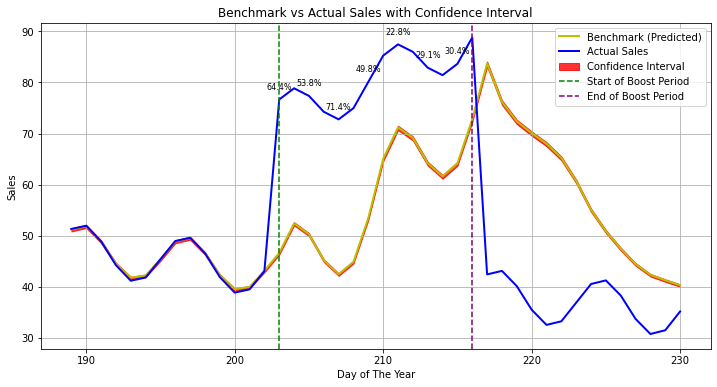

In [110]:
boost_mask = (predictions_backtest.index >= start_week_index) & (predictions_backtest.index <= end_week_index)
uplift_percentage = np.where(predictions_backtest['pred'].values[boost_mask] != 0, 
                              (predictions_backtest['actual'].values[boost_mask] - predictions_backtest['pred'].values[boost_mask]) / predictions_backtest['pred'].values[boost_mask] * 100, 
                              0)

# Create a new DataFrame for the uplift percentages
uplift_df = pd.DataFrame({
    'Day': predictions_backtest.index[boost_mask],
    'Uplift (%)': uplift_percentage
})

plt.figure(figsize=(12, 6))

# Plot the predictions and actual sales
plt.plot(predictions_backtest['pred'], color='y', label='Benchmark (Predicted)', linewidth=2)
plt.plot(predictions_backtest['actual'], color='b', label='Actual Sales', linewidth=2)

# Fill the area between lower and upper bounds for confidence intervals
plt.fill_between(
    predictions_backtest.index, 
    predictions_backtest['lower_bound'], 
    predictions_backtest['upper_bound'], 
    color='r', alpha=0.8, label='Confidence Interval'
)

# Add vertical lines for start and end of the boost period
plt.axvline(start_week_index, color='green', linestyle='--', label='Start of Boost Period')
plt.axvline(end_week_index, color='purple', linestyle='--', label='End of Boost Period')

for i, uplift in enumerate(uplift_df['Uplift (%)']):
    if i % 2 == 0:  # Annotate every other uplift value to reduce clutter
        plt.annotate(f'{uplift:.1f}%', 
                     (predictions_backtest.index[i+14], predictions_backtest['actual'].iloc[i+14]),  # Positioning at actual sales values
                     textcoords="offset points", 
                     xytext=(0, 10),  # Adjust vertical position
                     ha='center', 
                     fontsize=8, 
                     color='black')


# Add grid, title, labels, and legend
plt.grid(True)
plt.legend()
plt.title('Benchmark vs Actual Sales with Confidence Interval')
plt.xlabel('Day of The Year')
plt.ylabel('Sales')

# Show the plot
plt.show()
